<a href="https://colab.research.google.com/github/vimita/Predictive_Modeling-Deep-Learning-/blob/master/Pytorch_modeling_validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
from google.colab import drive 
drive.mount('/content/my-drive')


Drive already mounted at /content/my-drive; to attempt to forcibly remount, call drive.mount("/content/my-drive", force_remount=True).


In [25]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [26]:
nz_crime_data=pd.read_csv('my-drive/My Drive/Deep Learning(Predictive Policing)/nz_crime_dataset_new.csv', encoding='utf-8-sig')

In [27]:
# Count total NaN at each column in DataFrame
print(nz_crime_data.isnull().sum())

# Count all NaN in a DataFrame (both columns & Rows)
print(nz_crime_data.isnull().sum().sum())

# erase every row (axis=0) that has "any" Null value in it.
nz_crime_data = nz_crime_data.dropna(how='any',axis=0)

DATE_NO_TIME                 0
DATE_TIME                    0
DAY_AREA_CRIME_COUNT_ROLL    0
DAY_AREA_CRIME_COUNT         0
MONTH_AREA_CRIME_COUNT       0
YEAR_AREA_CRIME_COUNT        0
TIME_SINCE_LAST_CRIME        0
MONTH                        0
QUARTER                      0
DAY_OF_WEEK                  0
DAY                          0
HOUR                         0
HOUR_PARTITION               0
MESHBLOCK                    0
AREA_0                       0
AREA_1                       0
WEAPON_TYPE                  0
CRIME_TYPE                   0
RISK                         0
dtype: int64
0


In [28]:
feature_var = ['DAY_AREA_CRIME_COUNT_ROLL', 'MONTH', 'DAY', 'QUARTER', 'HOUR_PARTITION', 'WEAPON_TYPE','AREA_0','AREA_1','CRIME_TYPE']
response_var = 'RISK'

X = nz_crime_data[feature_var]
y = nz_crime_data.pop(response_var)



In [29]:
# Encode categorical variables
from sklearn.preprocessing import OrdinalEncoder
oe = OrdinalEncoder()
oe.fit(X)
X = oe.transform(X)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(y)
y = le.transform(y)

In [30]:
# Split into train+val and test
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.4, stratify=y, random_state=69)

# Split train into train-val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, stratify=y_trainval, random_state=21)

In [31]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

In [32]:
def get_class_distribution(obj):
    count_dict = {
        "rating_3": 0,
        "rating_4": 0,
        "rating_5": 0,
        "rating_6": 0,
        "rating_7": 0,
        "rating_8": 0,
    }
    
    for i in obj:
        if i == 0: 
            count_dict['rating_3'] += 1
        elif i == 1: 
            count_dict['rating_4'] += 1
        elif i == 2: 
            count_dict['rating_5'] += 1
        elif i == 3: 
            count_dict['rating_6'] += 1
        elif i == 4: 
            count_dict['rating_7'] += 1  
        elif i == 5: 
            count_dict['rating_8'] += 1              
        else:
            print("Check classes.")
            
    return count_dict

Text(0.5, 1.0, 'Class Distribution in Test Set')

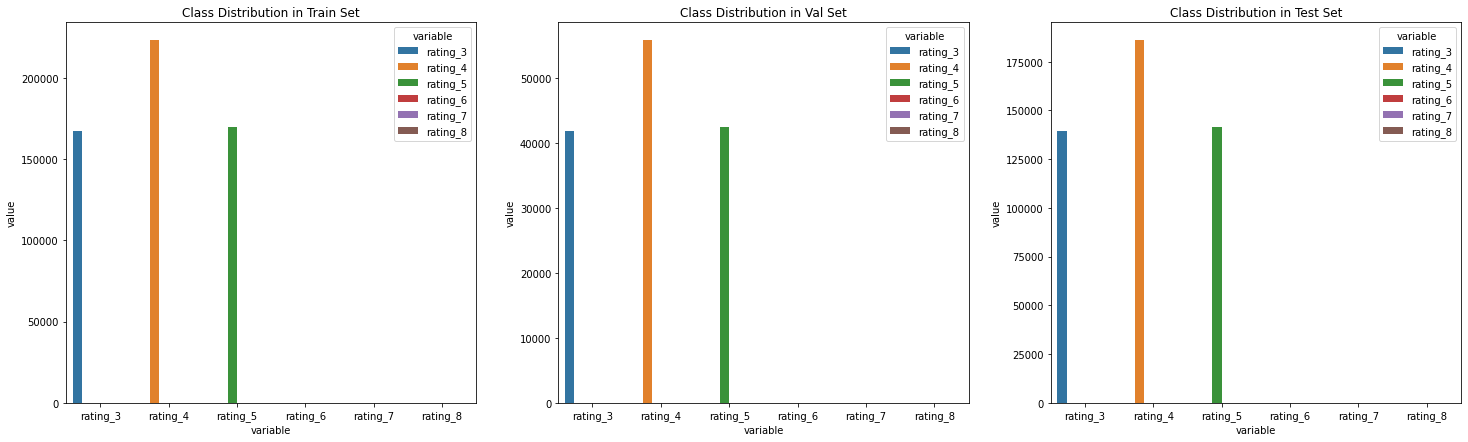

In [33]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,7))
# Train
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_train)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[0]).set_title('Class Distribution in Train Set')
# Validation
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_val)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[1]).set_title('Class Distribution in Val Set')
# Test
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_test)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[2]).set_title('Class Distribution in Test Set')


In [34]:
class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_dataset = ClassifierDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
test_dataset = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

In [35]:
target_list = []
for _, t in train_dataset:
    target_list.append(t)
    
target_list = torch.tensor(target_list)
target_list = target_list[torch.randperm(len(target_list))]

In [36]:
class_count = [i for i in get_class_distribution(y_train).values()]
class_weights = 1./torch.tensor(class_count, dtype=torch.float) 
print(class_weights)

tensor([5.9773e-06, 4.4832e-06, 5.8835e-06,        inf,        inf,        inf])


In [37]:
class_weights_all = class_weights[target_list]

In [38]:
weighted_sampler = WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)

In [39]:
EPOCHS = 64
BATCH_SIZE = 16
LEARNING_RATE = 0.001
NUM_FEATURES = 9
NUM_CLASSES = 6

In [40]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          sampler=weighted_sampler
)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [41]:
class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 512)
        self.layer_2 = nn.Linear(512, 128)
        self.layer_3 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, num_class) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(64)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x)
        
        return x

In [42]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [43]:
model = MulticlassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
model.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
print(model)

MulticlassClassification(
  (layer_1): Linear(in_features=9, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=6, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [44]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc) * 100
    
    return acc

In [45]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [46]:
print("Begin training.")
for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
        loss_stats['train'].append(train_epoch_loss/len(train_loader))
        loss_stats['val'].append(val_epoch_loss/len(val_loader))
        accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
        accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
                              
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')


Begin training.


Epoch 001: | Train Loss: 1.04325 | Val Loss: 1.01769 | Train Acc: 24.074| Val Acc: 47.182
Epoch 002: | Train Loss: 1.02916 | Val Loss: 1.01215 | Train Acc: 27.926| Val Acc: 47.491
Epoch 003: | Train Loss: 1.02425 | Val Loss: 1.00610 | Train Acc: 29.916| Val Acc: 48.906
Epoch 004: | Train Loss: 1.02241 | Val Loss: 1.00623 | Train Acc: 30.196| Val Acc: 47.801
Epoch 005: | Train Loss: 1.01913 | Val Loss: 0.99965 | Train Acc: 31.238| Val Acc: 48.352
Epoch 006: | Train Loss: 1.01832 | Val Loss: 1.00835 | Train Acc: 31.039| Val Acc: 46.943
Epoch 007: | Train Loss: 1.01730 | Val Loss: 1.00055 | Train Acc: 31.678| Val Acc: 49.040
Epoch 008: | Train Loss: 1.01434 | Val Loss: 0.99941 | Train Acc: 32.743| Val Acc: 48.602
Epoch 009: | Train Loss: 1.01496 | Val Loss: 0.99280 | Train Acc: 32.232| Val Acc: 49.624
Epoch 010: | Train Loss: 1.01486 | Val Loss: 0.99124 | Train Acc: 32.292| Val Acc: 49.815
Epoch 011: | Train Loss: 1.01479 | Val Loss: 0.99304 | Train Acc: 32.578| Val Acc: 49.862
Epoch 012:

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

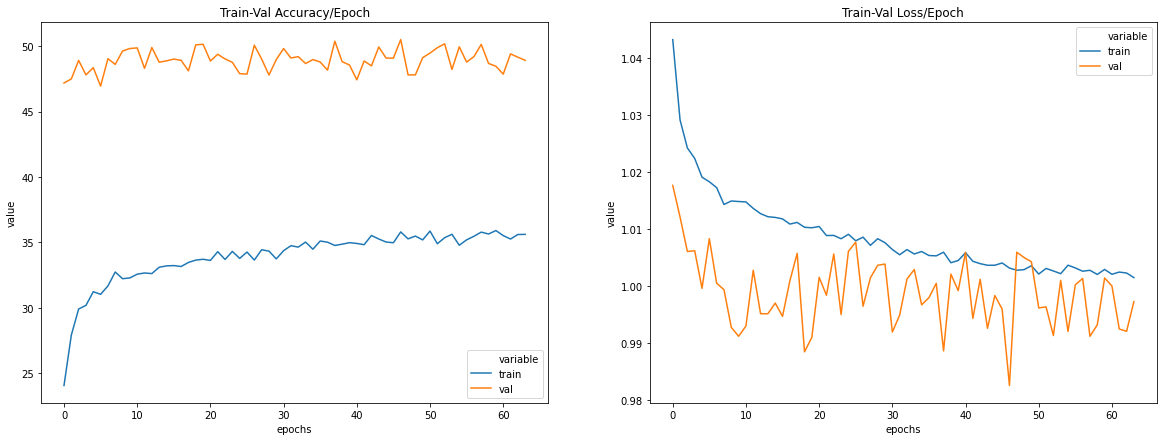

In [47]:
# Create dataframes
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

In [51]:
y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_pred_softmax = torch.log_softmax(y_test_pred, dim = 1)
        _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]


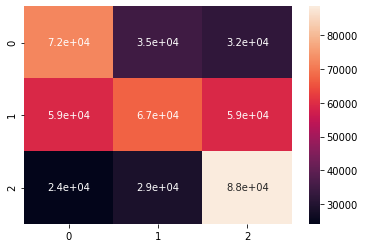

In [53]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred_list))

sns.heatmap(confusion_matrix_df, annot=True)

In [52]:
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       0.46      0.52      0.49    139417
           1       0.51      0.36      0.43    185882
           2       0.49      0.62      0.55    141640

    accuracy                           0.49    466939
   macro avg       0.49      0.50      0.49    466939
weighted avg       0.49      0.49      0.48    466939

